In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [3]:
# pip install pyodbc pandas

# 1. Import thư viện và tải dữ liệu

#### **Import dữ liệu và thư viện**

In [4]:
import pyodbc
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import datetime
import math
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
import plotly as py
from sklearn.metrics import silhouette_samples, silhouette_score
import plotly.graph_objs as go
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

In [5]:
import pyodbc
pyodbc.drivers()

['SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)',
 'SQL Server Native Client 11.0',
 'SQL Server Native Client RDA 11.0',
 'ODBC Driver 17 for SQL Server']

In [6]:
server = r'DESKTOP-5L4FBAL\MSSQLSERVER2022'
database = 'Olist_ECommerce_WH'
conn_str = (
    'DRIVER={ODBC Driver 17 for SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    'Trusted_Connection=yes;'
)

conn = pyodbc.connect(conn_str)

Hàm dưới đây sẽ phục vụ cho việc vẽ các biểu đồ phân phối

In [7]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

In [8]:
query = """
SELECT
    customer_key,
    recency_days,
    frequency,
    amount,
    clusters
FROM mart.customer_rfm_clusters;
"""

In [9]:
df = pd.read_sql(query, conn)

conn.close()

df.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9420\3103149744.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,customer_key,recency_days,frequency,amount,clusters
0,1,337,1,196.89,0
1,2,180,1,35.38,4
2,3,456,1,29.00,3
3,4,207,1,63.66,4
4,5,177,1,82.05,4


# 2. Hiểu dữ liệu

#### **Hiển thị thông tin mô tả của bộ dữ liệu, bao gồm các giá trị như min, max, mean, std ...**

In [10]:
df.describe()

,customer_key,recency_days,frequency,amount,clusters
count,96093.000000,96093.000000,96093.000000,96093.000000,96093.000000
mean,48048.942545,288.109019,1.034800,174.210525,2.220078
std,27740.951426,153.408499,0.214364,265.522992,1.488833
min,1.000000,0.000000,1.000000,10.070000,0.000000
25%,24025.000000,164.000000,1.000000,64.040000,0.000000
50%,48050.000000,269.000000,1.000000,110.800000,3.000000
75%,72073.000000,397.000000,1.000000,188.580000,3.000000
max,96096.000000,773.000000,17.000000,13664.080000,4.000000


In [11]:
df[['customer_key', 'recency_days']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
customer_key,96093.0,48048.942545,27740.951426,1.0,24025.0,48050.0,72073.0,96096.0
recency_days,96093.0,288.109019,153.408499,0.0,164.0,269.0,397.0,773.0


#### **Trực quan hoá biến Recency bằng cách sử dụng Hàm QQ_plot**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9420\2679653009.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


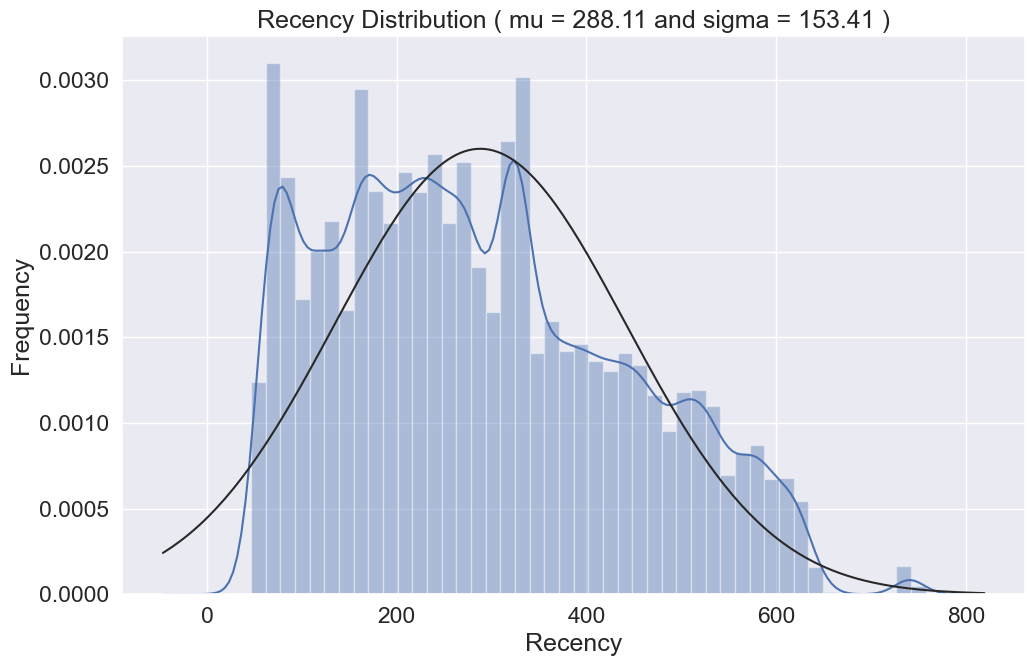

In [12]:
# probplot(rfm['recency'], dist=norm, plot=plt)
QQ_plot(df['recency_days'], 'Recency')

Từ biểu trên, chúng ta có thể thấy rằng phân phối của Recency bị lệch đôi chút, có đỉnh ở bên trái và đuôi dài về bên phải. Nó lệch khỏi phân phối chuẩn và có xu hướng dương.


#### **Trực quan hoá Frequency với hàm QQ_plot**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9420\2679653009.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


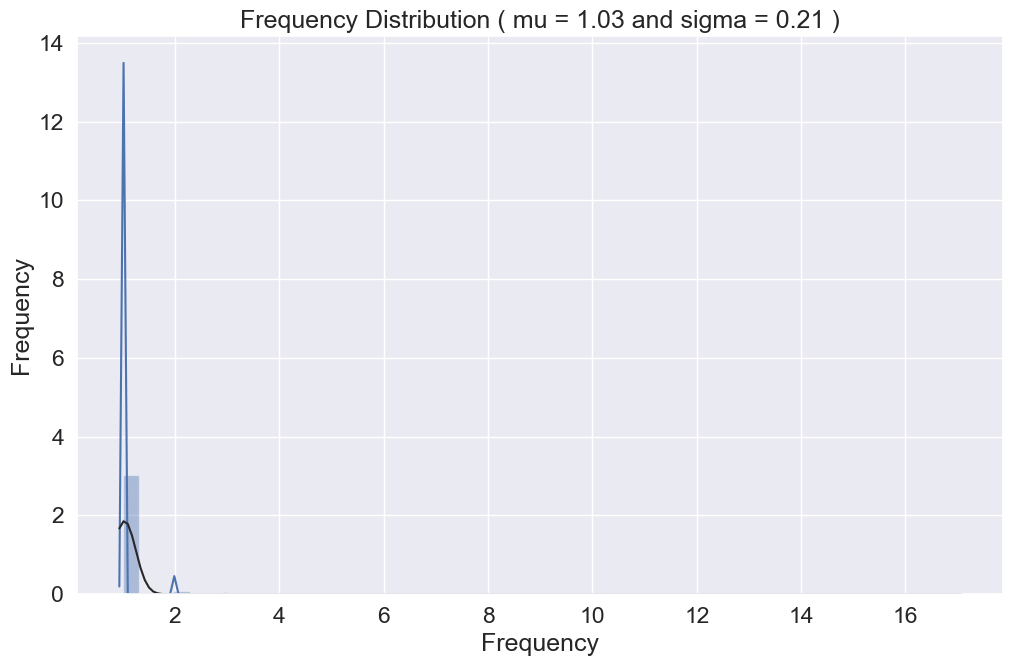

In [13]:
QQ_plot(df['frequency'], 'Frequency')

Từ biểu trên, chúng ta có thể thấy rằng phân phối tần suất bán hàng bị lệch rất lớn, có đỉnh ở bên trái và đuôi dài ở bên phải. Nó lệch khỏi phân phối chuẩn và có xu hướng dương.

#### **Trực quan hoá Monetary Value với hàm QQ_plot**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9420\2679653009.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


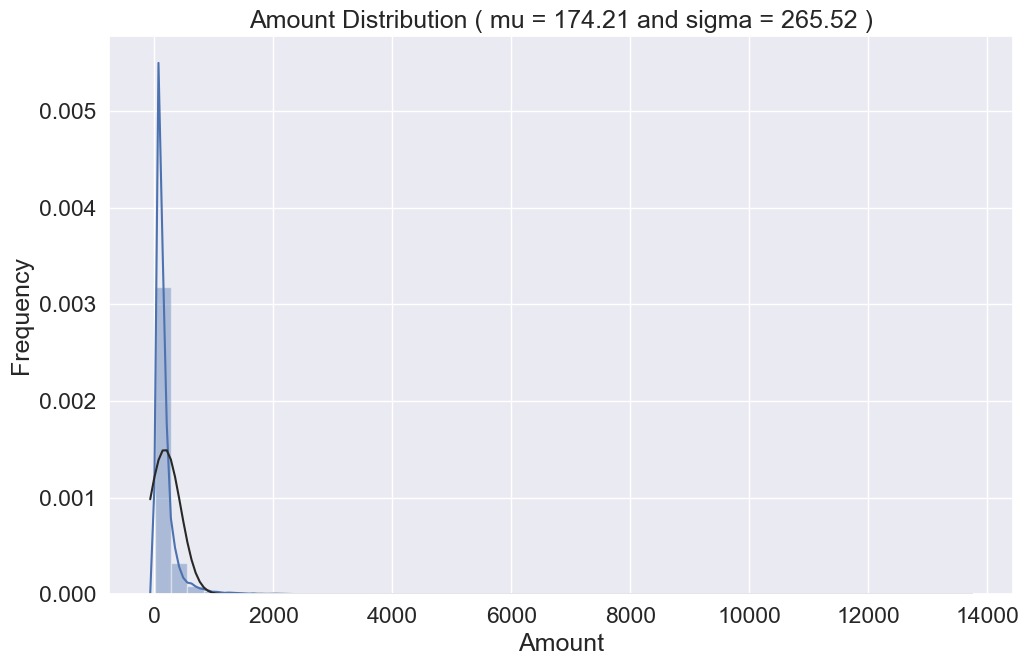

In [14]:
QQ_plot(df['amount'], 'Amount')

Từ biểu trên, chúng ta có thể thấy rằng phân phối  Monetary Value bị lệch, có đỉnh ở bên trái và đuôi dài ở bên phải. Nó lệch khỏi phân phối chuẩn và có xu hướng dương.


#### **Scale RBM trên thang đo log sau đó chuẩn hoá lại với StandardScaler**

Gợi ý: Sử dụng apply trong pandas kết hợp với math.log


In [15]:
df_log = df[['recency_days', 'frequency', 'amount']].apply(lambda x: np.log1p(x))
# chuyển đổi vị trí cột cho các tasks phía sau:
df_cols_order = ['amount', 'recency_days', 'frequency']
df_log = df_log[df_cols_order]
rfm_log_df = df_log.rename(columns={'amount': 'amount_log', 'recency_days': 'recency_log', 'frequency': 'frequency_log'})
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_log)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['amount_log', 'recency_log', 'frequency_log'])
rfm_scaled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
amount_log,96093.0,-5.962413e-16,1.000005,-2.851407,-0.705951,-0.049617,0.590228,5.773192
recency_log,96093.0,1.044005e-15,1.000005,-8.884112,-0.634816,0.160842,0.787753,1.862338
frequency_log,96093.0,-4.007723e-17,1.000005,-0.173565,-0.173565,-0.173565,-0.173565,27.906309


#### **Thực hiện vẽ biểu đồ Scatter và đưa ra nhận xét**

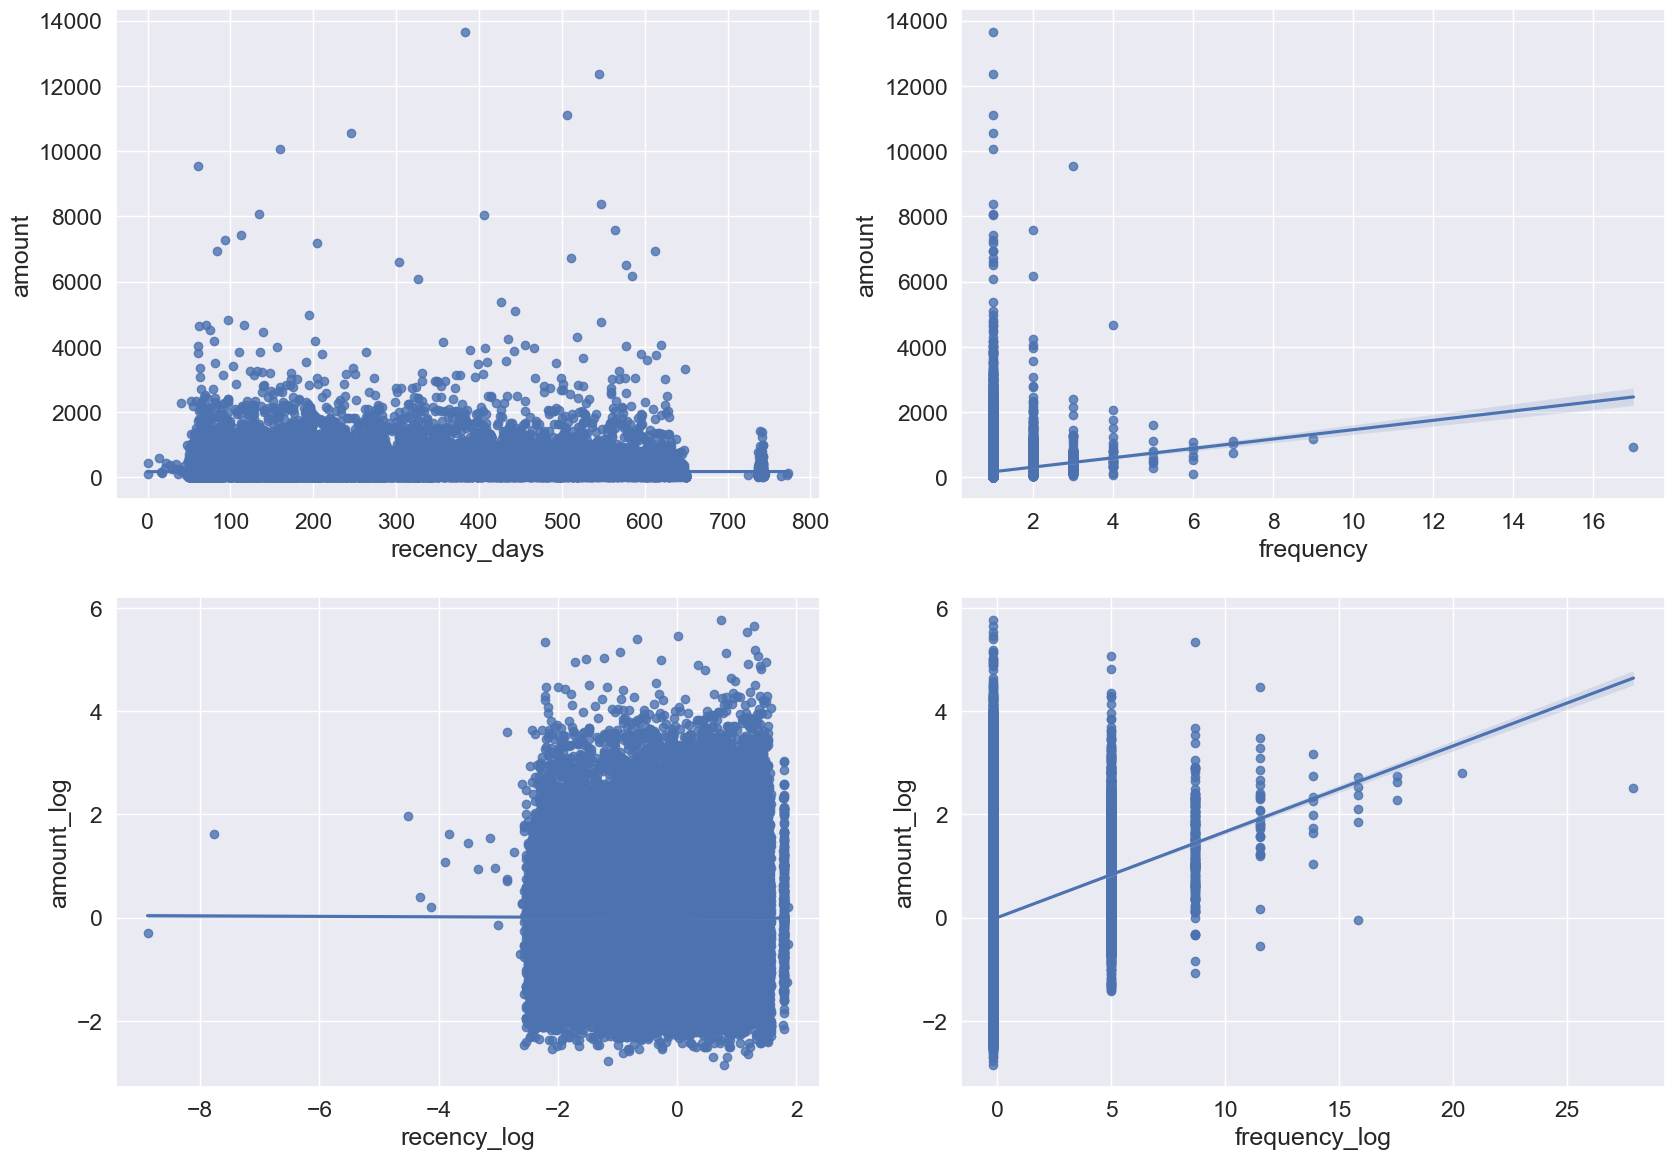

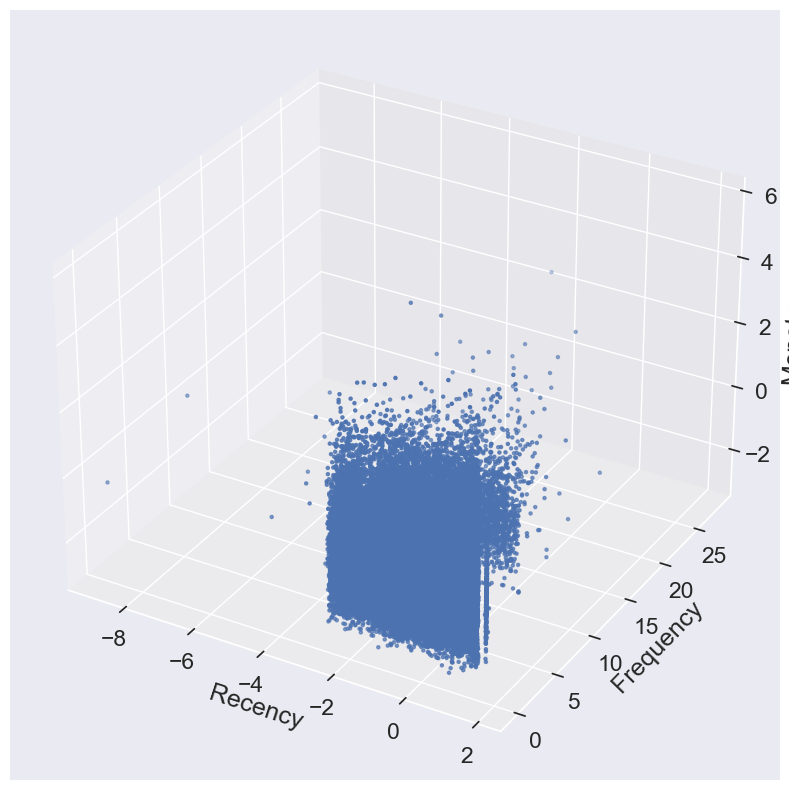

In [16]:
fig = plt.figure(figsize=(20,14))
# f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
# f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
# f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
# f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(221); sns.regplot(x='recency_days', y='amount', data=df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=rfm_scaled_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=rfm_scaled_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =rfm_scaled_df.recency_log
ys = rfm_scaled_df.frequency_log
zs = rfm_scaled_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

Dựa vào biểu đồ recency - amount:
Nhóm 1 recency 0-100, chi tiêu trung bình khá -> khách mới
Nhóm 2 recency 100-200, chi tiêu khá -> khách cũ, có xu hướng rời bỏ
Nhóm 3 recency 300-600, chi tiêu cao -> khách cũ chi tiêu lớn, không hoạt động lâu
Nhóm 4 recency 700-800, chi tiêu thấp -> khách cũ, chi tiêu ít, gần như đã không còn hoạt động, rời bỏ sàn
Dựa vào biểu đồ frequency - amount: tương quan tuyến tính rõ quay lại nhiều lần chi tiêu 
Nhóm frequency 0-2, chi tiêu rất cao -> khách mới mua 1-2 lần đầu, siêu VIP
Nhóm frequency 2+, chi tiêu vừa phải, không cao -> khách quay lại nhiều lần, có chi tiêu không cao, khách trung thành nhưng có chi têu thấp

# 4. Modeling - Kmean

#### **Phương pháp Elbow:**

Sử dụng phương pháp khuỷu tay (Elbow) để tìm số lượng cụm tối ưu. Ý tưởng đằng sau phương pháp khuỷu tay là xác định giá trị của k tại đó độ gấp khúc bắt đầu tăng nhanh nhất. Nếu k tăng, độ biến dạng của các cụm sẽ giảm, bởi vì các mẫu sẽ gần với trọng tâm cụm.

Phương pháp này xem xét phần trăm phương sai được giải thích như một hàm của số lượng cụm. Chính xác hơn, nếu ta vẽ biểu đồ phần trăm phương sai được giải thích bởi các cụm so với số lượng các cụm, các cụm đầu tiên sẽ bổ sung nhiều thông tin (giải thích nhiều phương sai), nhưng tại một số điểm, mức tăng cận biên sẽ giảm xuống (Số lượng cụm tăng, phương sai giảm), tạo ra một góc trong đồ thị, đây sẽ là điểm chọn số lượng cho cụm, do đó có "tiêu chí khuỷu tay". Phần trăm phương sai được giải thích là tỷ lệ giữa phương sai giữa nhóm với tổng phương sai, còn được gọi là F-test. Một biến thể nhỏ của phương pháp này vẽ biểu đồ độ cong của phương sai trong cụm

#### **Yêu cầu 14: Thực hiện đoạn mã bên dưới với X_scaled chính là dữ liệu sau khi chuẩn hoá, X_scaled sẽ có chiều như sau: (4338, 3)**

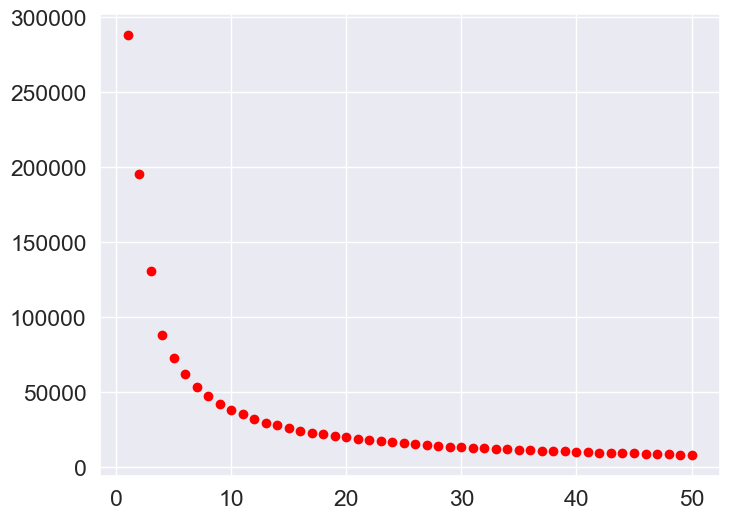

The best K sugest:  9


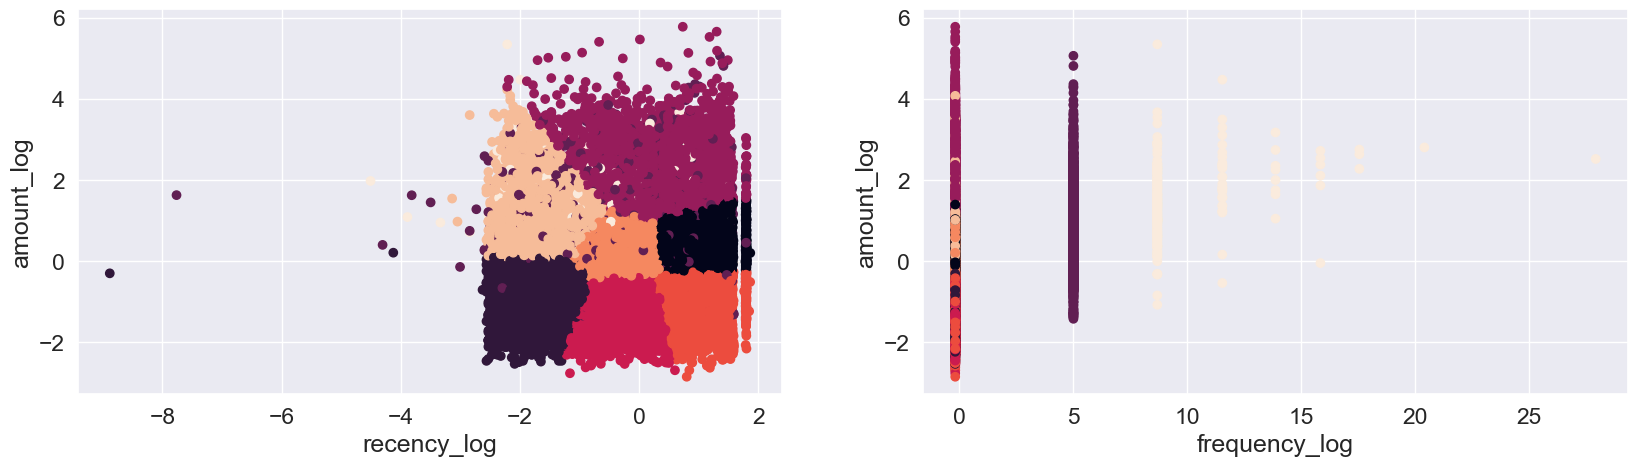

In [17]:
X_scaled = rfm_scaled
cl = 50
corte = 0.1
feature_vector = rfm_scaled_df.columns.to_list()

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

Khi sử dụng phương pháp Elbow bắt đầu với K bằng 3, chúng ta quan sát thấy với k = 9 thì độ giảm phương sai của cụm mạnh nhất với 10%. Từ đặc điểm này nên chúng ta sẽ bắt đầu đánh giá sâu hơn với k từ 3 đến 9. Chúng ta sẽ sử dụng phương pháp phân tích Silhouette.

**Bổ sung lý thuyết:**

Phân tích **Silhouette** trong phân cụm Kmeans

Phân tích Silhouette có thể được sử dụng để nghiên cứu khoảng cách giữa các cụm , như một chiến lược để định lượng chất lượng của việc phân nhóm hay phân cụm thông qua trực quan hoá để vẽ biểu đồ đo lường mức độ "chặt chẽ nhóm" của các mẫu trong các cụm. Biểu đồ Silhouette hiển thị thước đo mức độ gần của mỗi điểm trong một cụm với các điểm trong các cụm lân cận và do đó cung cấp cách để đánh giá các thông số như số lượng cụm một cách trực quan.

Cách phân tích này cũng có thể được áp dụng cho các thuật toán phân cụm khác ngoài k-means.

Hệ số Silhouette có phạm vi [-1, 1], và được tính bằng:
1. a(i) là khoảng cách trung bình giữa mẫu x(i) và tất cả các điểm khác trong cùng một cụm.
2. b(i) từ cụm gần nhất tiếp theo là khoảng cách trung bình giữa mẫu x(i) và tất cả các mẫu trong cụm gần nhất.
3. s(i) là sự khác biệt giữa a(i) và b(i) chia cho max(a(i), b(i)), như được hiển thị ở đây:

\begin{align} 
\text{s(i)} = \frac{b(i) - a(i)}{max\{a(i), b(i)\}} 
\end{align}

Một cách viết khác của công thức trên:

\begin{align}
        \text{s}(i) = \left\{
        \begin{array}{cl}
        1 - a(i)/b(i), & \text{if } a(i) < b(i) \\
        0, & \text{if } a(i) = b(i) \\
        b(i)/a(i) - 1, & \text{if } a(i) > b(i)
        \end{array}
        \right.
    \end{align}

Trong đó:
* Nếu gần +1, có nghĩa rằng mẫu ở xa các cụm lân cận.
* Giá trị cao chỉ ra rằng đối tượng được đối sánh tốt với cụm riêng của nó và đối sánh kém với các cụm lân cận.
* Nếu hầu hết các đối tượng có giá trị cao, thì cấu hình phân cụm là thích hợp.
* Nếu nhiều điểm có giá trị thấp hoặc âm, thì cấu hình phân cụm có thể có quá nhiều hoặc quá ít cụm.
* Giá trị 0 cho biết mẫu nằm trên hoặc rất gần ranh giới quyết định giữa hai cụm lân cận
* Giá trị âm chỉ ra rằng những mẫu đó có thể đã được chỉ định vào sai nhóm.

K được coi là không tốt khi các cụm có điểm Silhouette dưới trung bình hoặc có sự biến động lớn về kích thước của các ô Silhouette. K được coi là tốt khi tất cả các ô có độ dày tương tự hoặc không khác nhau nhiều hay nói cách khác tất cả các ô có kích thước tương tự.

Mặc dù chúng ta phải lưu ý rằng trong một số trường hợp và tình huống, đôi khi chúng ta có thể phải loại bỏ giải thích toán học do thuật toán đưa ra và xem xét mức độ phù hợp kinh doanh của kết quả thu được.

Hãy xem dữ liệu của chúng ta hoạt động như thế nào đối với từng giá trị K (3, 5 và 7) trong điểm Silhouette của mỗi cụm, cùng với trọng tâm của mỗi cụm được được đánh dấu trong các biểu đồ scatter, chúng ta sẽ phân cụm với 3 biến đầu vào là amount_log, recency_log, frequency_log nhưng sẽ hiển thị trên scatter theo từng cặp (amount_log, recency_log) và (amount_log, frequency_log)



#### **Vẽ biểu đồ tìm hê số Silhouette cho các phân cụm K**

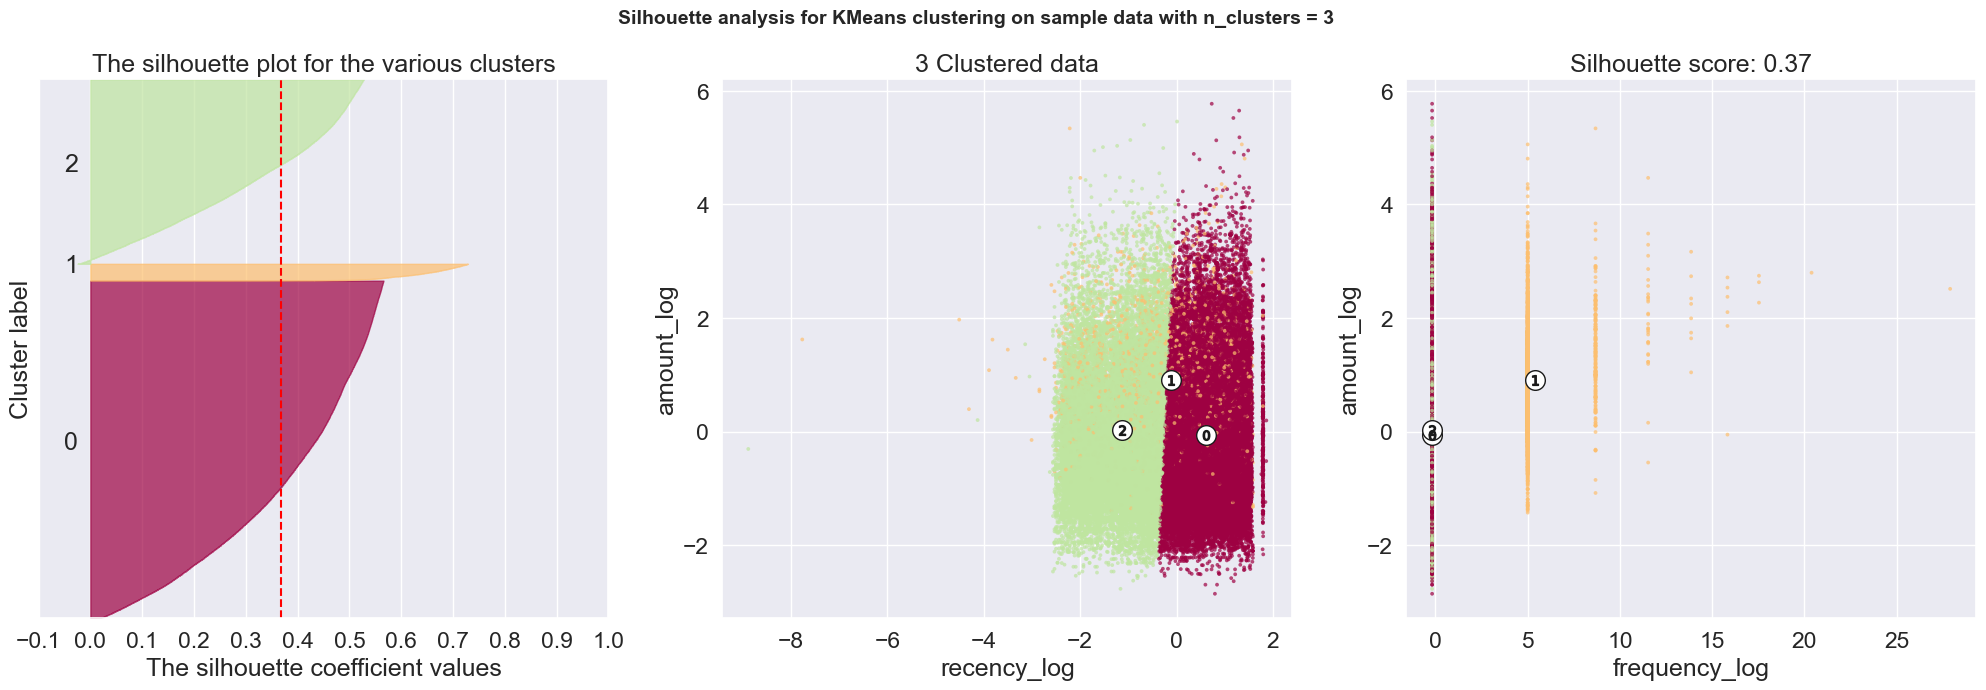

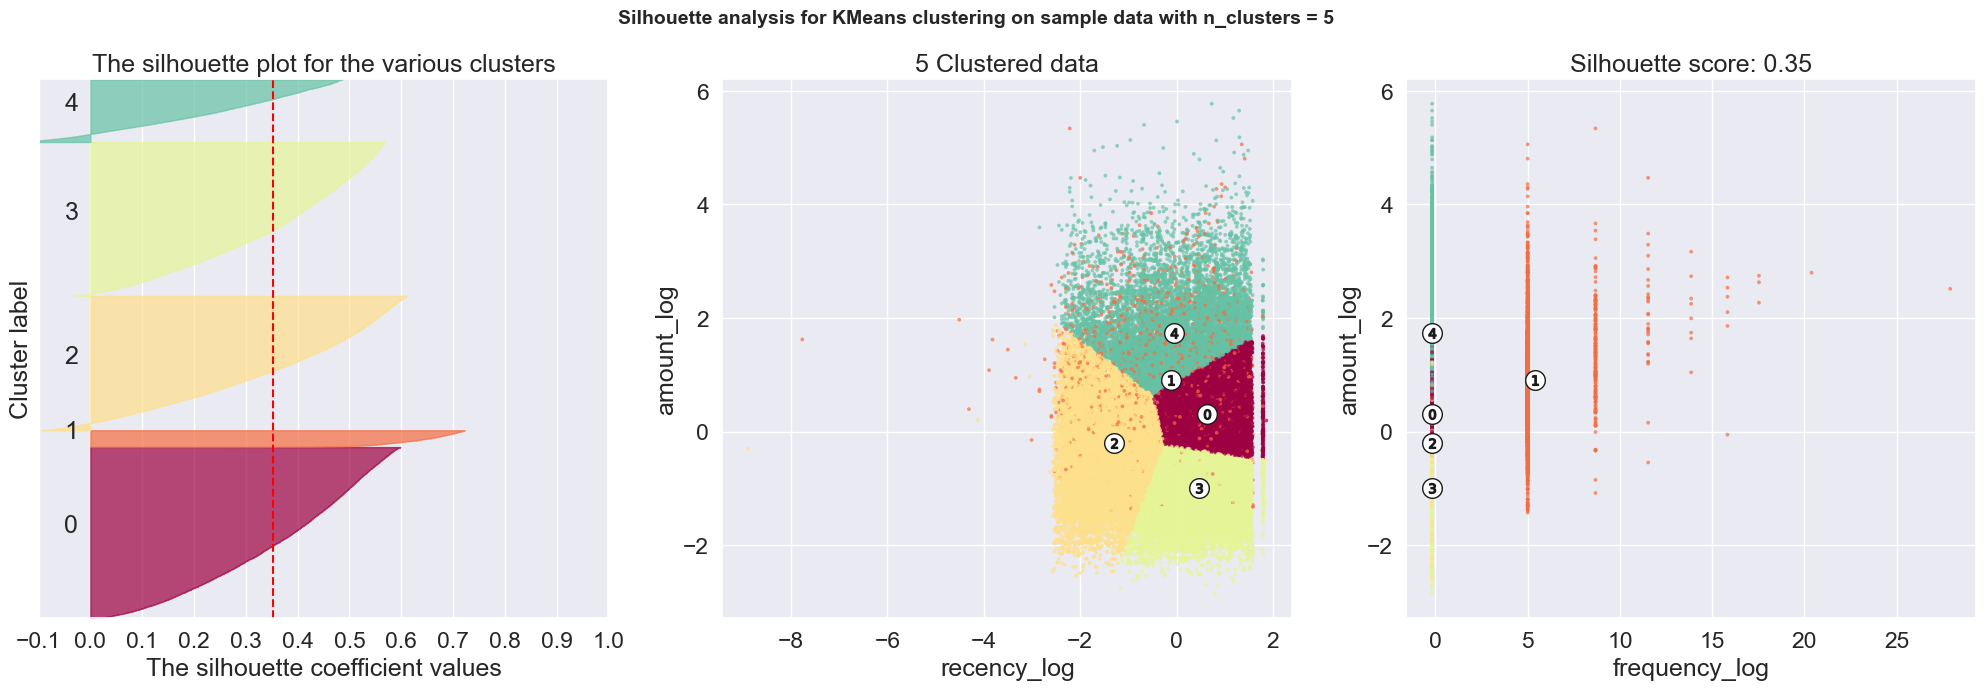

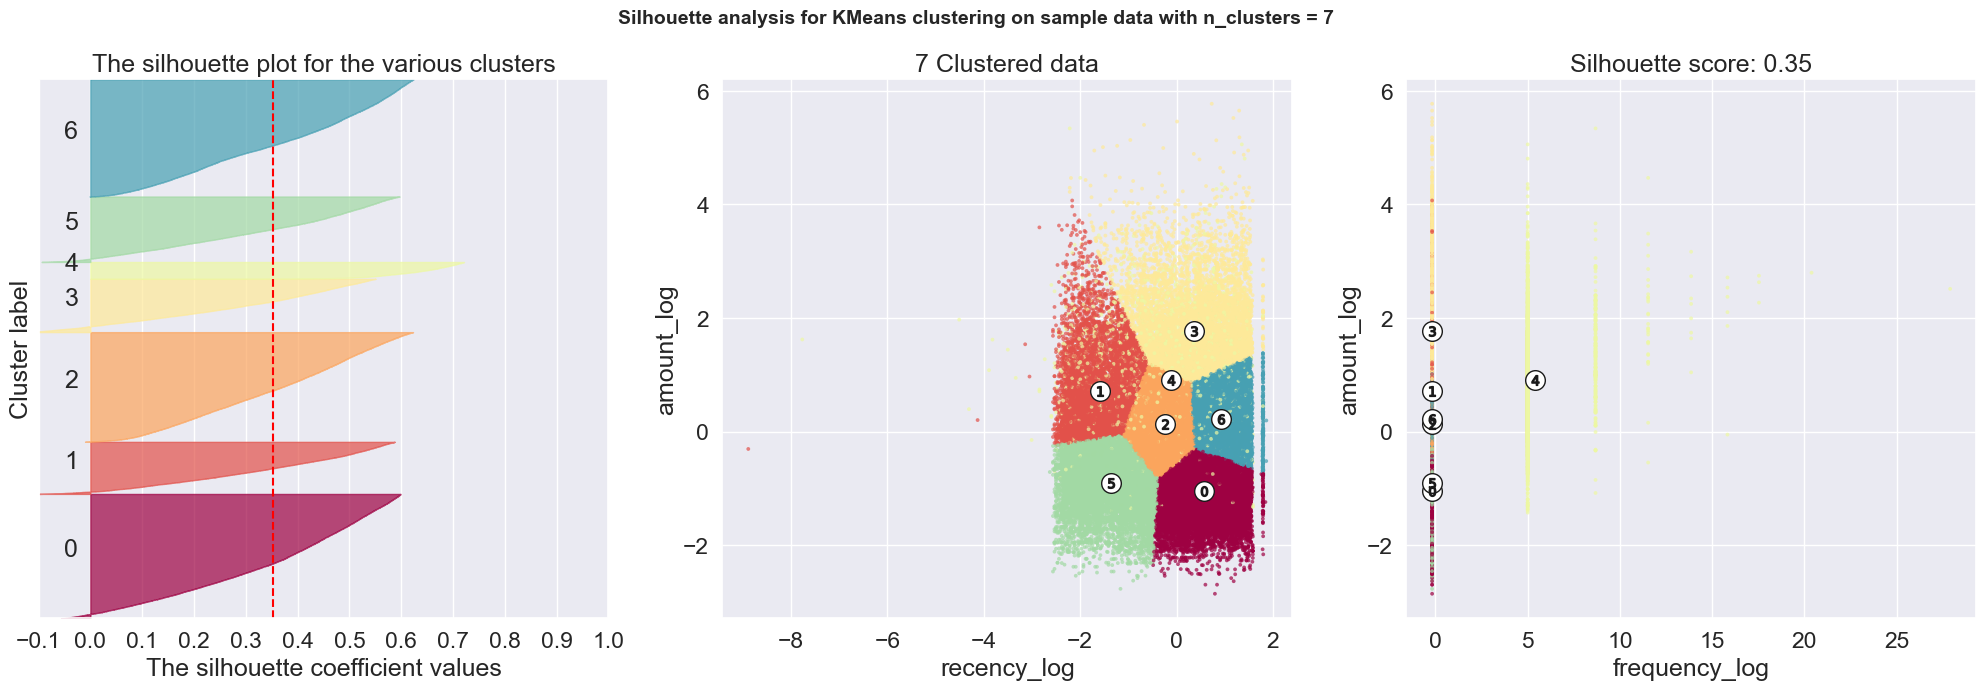

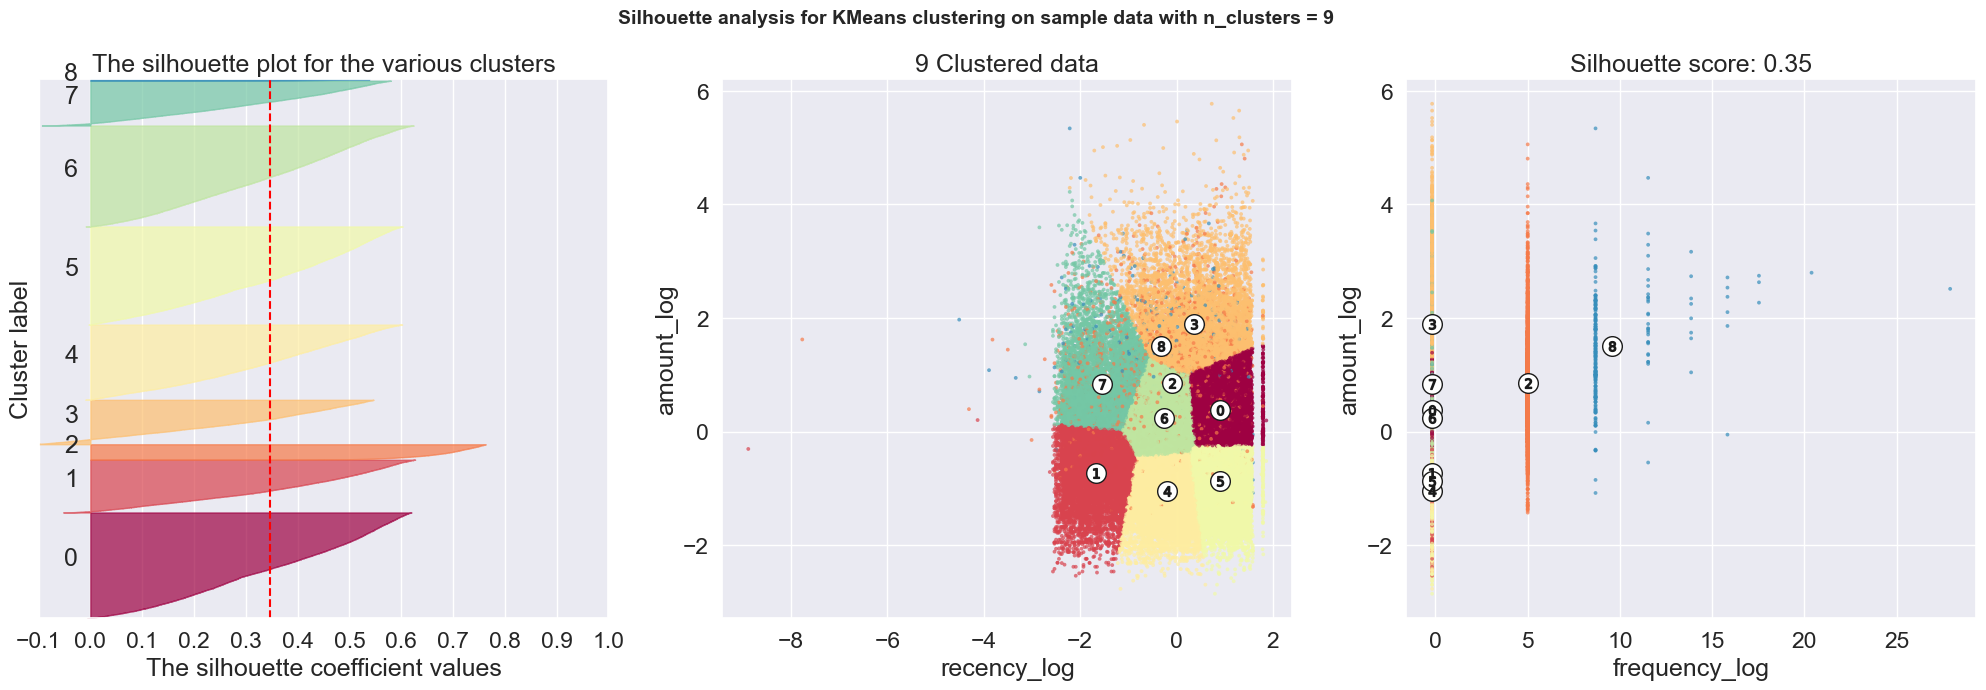

In [18]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

#### **Từ hình ảnh trực quan ở yêu cầu 15 hãy đưa ra một số nhận xét chung**

### Nhận xét tổng quan về mô hình Kmeans dựa trên biểu đồ trực quan:
#### 1/ Với phân cụm k=3:
- hệ số silhouette là 0.37
- các cụm dữ liệu phân tách không rõ ràng chồng lấn, đặc biệt là cụm 1 phân chia rất nhỏ
- khách hàng bị chia vào các quá ít cụm không có cơ sở để phân biệt các đặc điểm khách trong từng cụm
#### 2/ Với phân cụm k=5:
- hệ số silhouette là 0.35
- các cụm dữ liệu có sự chồng lấn nhẹ những vẫn rõ ràng, mang ý nghĩa thực tế 
- khách hàng được chia vào 5 cụm khá phù hợp với phân tích biểu đồ phân bố dữ liệu RFM
#### 3/ Với phân cụm k=7,9:
- hệ số silhouette là 0.35 không thay đổi nhiều
- các cụm dữ liệu chia quá nhỏ, không đảm bảo được phân tích thực tế, không phù hớp với phân bố dữ liệu RFM
### Kết luận:
- với k=5, silhouette = 0.35 là sự lựa chọn tốt ưu cho mô hình để phân tích, đảm báo ý nghĩa phân cụm khách hàng trong kinh doanh.

##  Clusters Center

Hãy xem xét các giá trị trung tâm cụm được ánh xạ ngược lại từ các cụm tính trên thang đo log và Stardartcaler

#### **Chạy đoạn mã bên dưới để hiển thị các tâm cụm**

In [19]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.37
Centers of each cluster:
       amount     recency  frequency
0  110.448819  358.625249   2.000000
1  246.302372  226.825464   3.091788
2  119.898811  122.007243   2.000000
--------------------------------------------------
for 5 clusters the silhouette score is 0.35
Centers of each cluster:
       amount     recency  frequency
0  150.463326  361.987458   2.000000
1  246.302372  226.825464   3.091788
2   99.416237  108.984690   2.000000
3   51.814241  327.109287   2.000000
4  487.050476  235.685860   2.000000
--------------------------------------------------
for 7 clusters the silhouette score is 0.35
Centers of each cluster:
       amount     recency  frequency
0   49.403506  348.691241   2.000000
1  210.404434   91.712917   2.000000
2  130.405635  210.260692   2.000000
3  504.578871  306.706671   2.000000
4  246.302372  226.825464   3.091788
5   55.103916  105.344036   2.000000
6  139.760619  435.083935   2.000000
-------------------------

   customer_key  recency_days  frequency  amount  recency_log  frequency_log  \
0             1           337          1  196.89     0.523750      -0.173565   
1             2           180          1   35.38    -0.485287      -0.173565   
2             3           456          1   29.00     1.011083      -0.173565   
3             4           207          1   63.66    -0.260649      -0.173565   
4             5           177          1   82.05    -0.512290      -0.173565   

   amount_log  clusters_3  clusters_5  clusters_7  
0    0.642206           0           0           0  
1   -1.409870           2           4           4  
2   -1.643493           0           3           3  
3   -0.713051           0           4           4  
4   -0.409788           2           4           4  


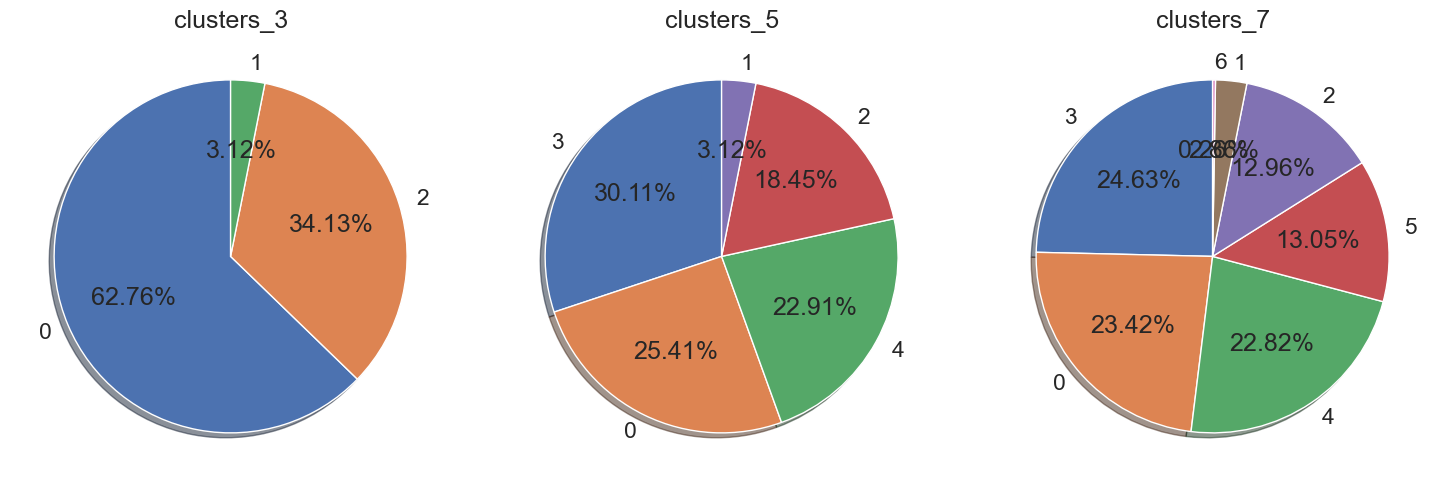

In [20]:
# tạo bảng tổng hợp nối dữ liệu lại theo hàng ngang và đổi vị trí cột trong bảng
rfm_cluster_df = pd.concat([df, rfm_scaled_df], axis=1)
rfm_cluster_df = rfm_cluster_df[['customer_key', 'recency_days', 'frequency', 'amount', 'recency_log', 'frequency_log', 'amount_log']]

# gắn nhãn cho CustomerID với các cột theo số clusters 3,5,7 
for k in [3, 5, 7]:
    model = KMeans(n_clusters=k, random_state=101)
    model.fit(X_scaled)
    rfm_cluster_df[f'clusters_{k}'] = model.labels_

print(rfm_cluster_df.head())

# Vẽ biểu đồ pie đối với từng cluster
x_3_counts = rfm_cluster_df['clusters_3'].value_counts()
x_5_counts = rfm_cluster_df['clusters_5'].value_counts()
x_7_counts = rfm_cluster_df['clusters_7'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(15,5))

axes[0].pie(x_3_counts, labels=x_3_counts.index, autopct='%.2f%%', startangle=90, shadow=True)
axes[0].set_title(x_3_counts.index.name)

axes[1].pie(x_5_counts, labels=x_5_counts.index, autopct='%.2f%%', startangle=90, shadow=True)
axes[1].set_title(x_5_counts.index.name)

axes[2].pie(x_7_counts, labels=x_7_counts.index, autopct='%.2f%%', startangle=90, shadow=True)
axes[2].set_title(x_7_counts.index.name)

plt.tight_layout()
plt.show()


In [21]:
rfm_cluster_df.head()

,customer_key,recency_days,frequency,amount,recency_log,frequency_log,amount_log,clusters_3,clusters_5,clusters_7
0,1,337,1,196.89,0.523750,-0.173565,0.642206,0,0,0
1,2,180,1,35.38,-0.485287,-0.173565,-1.409870,2,4,4
2,3,456,1,29.00,1.011083,-0.173565,-1.643493,0,3,3
3,4,207,1,63.66,-0.260649,-0.173565,-0.713051,0,4,4
4,5,177,1,82.05,-0.512290,-0.173565,-0.409788,2,4,4


# 5. Clusters Insights

#### **Phân tích với từng K=5**



#### Trường hợp có 5 cluster:
- cụm 0 Amount trung bình, Recency rất lâu, frequency 2 -> Khách đã không tương tác lâu, chi tiêu trung bình - In-Active Mid-value customers
- cụm 1 Amount khá, Recency lâu, frequency 3 -> Khách trung thành, mua nhiều và thường xuyên - Active High-Value Customers
- cụm 2 Amount thấp, Recency gần đây, frequency 2 -> Khách mới - New customers
- cụm 3 Amount rất thấp, Recency rất lâu, frequency 2 -> Khách chi tiêu thấp, gần như rời bỏ - At-Risk Low-Value Customers
- cụm 4 Amount rất cao, Recency khá lâu, frequency 2 -> Khách chi tiêu lớn, không thường xuyên quay lại  - High-Spending At-Risk Customers


In [22]:
clusters_name = {0: 'In-Active Mid-value customers', 
                 1: 'Active High-Value Customers', 
                 2: 'New customers', 
                 3: 'At-Risk Low-Value Customers',
                 4: 'High-Spending At-Risk Customers'}

cluster_desc_map = {
    0: 'Khách trung bình nhưng không quay lại rất lâu',
    1: 'Khách chi tiêu cao, tần suất tốt, còn hoạt động',
    2: 'Khách mới mua gần đây, giá trị trung bình',
    3: 'Khách chi tiêu thấp và gần như bỏ sàn',
    4: 'Khách chi tiêu cao nhưng có dấu hiệu rời bỏ'
}


In [23]:
df_customers_rfm_clusters_5 = rfm_cluster_df[['customer_key', 'clusters_5']]
df_update = df_customers_rfm_clusters_5.copy()


In [24]:
df_update['cluster_name'] = df_update['clusters_5'].map(clusters_name)

In [25]:
df_update['description'] = df_update['clusters_5'].map(cluster_desc_map)


In [ ]:
rfm_table = rfm_cluster_df[['customer_key', 'recency_days', 'frequency', 'amount', 'recency_log', 'frequency_log', 'amount_log']].copy()

In [60]:
rfm_table.to_csv(r'D:\Data Analysis\Furnix Data Analyst Course\Đồ án cuối khoá_phân tích dữ liệu\olist-ecommerce-analytics\07_Advance_Analytics\customer_segmentation_rfm_kmeans\outputs\rfm_table.csv', index=False)

In [31]:
df_k5 = rfm_cluster_df[['customer_key', 'recency_days', 'frequency', 'amount', 'clusters_5']].copy()
df_k5.rename(columns={'clusters_5': 'clusters'}, inplace=True)

In [34]:
df_k5.head()

,customer_key,recency_days,frequency,amount,clusters
0,1,337,1,196.89,0
1,2,180,1,35.38,4
2,3,456,1,29.00,3
3,4,207,1,63.66,4
4,5,177,1,82.05,4


In [47]:
cluster_summary = df_k5.groupby('clusters').agg(
                            customers=('customer_key', 'count'),
                            avg_recency_days=('recency_days', 'mean'),
                            avg_frequency=('frequency', 'mean'),
                            avg_amount=('amount', 'mean')).reset_index()
                                          
                              

In [48]:
cluster_summary['cluster_name'] = cluster_summary['clusters'].map(clusters_name)

In [49]:
cluster_summary['description'] = cluster_summary['clusters'].map(cluster_desc_map)

In [50]:
cluster_summary.head()

,clusters,customers,avg_recency_days,avg_frequency,avg_amount,cluster_name,description
0,0,24413,316.858805,1.000000,370.748517,In-Active Mid-value customers,Khách trung bình nhưng không quay lại rất lâu
1,1,2996,268.641188,2.116155,331.954239,Active High-Value Customers,"Khách chi tiêu cao, tần suất tốt, còn hoạt động"
2,2,17732,98.840627,1.000000,154.461338,New customers,"Khách mới mua gần đây, giá trị trung bình"
3,3,28934,438.047142,1.000000,89.235867,At-Risk Low-Value Customers,Khách chi tiêu thấp và gần như bỏ sàn
4,4,22018,214.271914,1.000000,62.400515,High-Spending At-Risk Customers,Khách chi tiêu cao nhưng có dấu hiệu rời bỏ


In [61]:
cluster_summary.to_csv(r'D:\Data Analysis\Furnix Data Analyst Course\Đồ án cuối khoá_phân tích dữ liệu\olist-ecommerce-analytics\07_Advance_Analytics\customer_segmentation_rfm_kmeans\outputs\cluster_summary.csv', index=False)


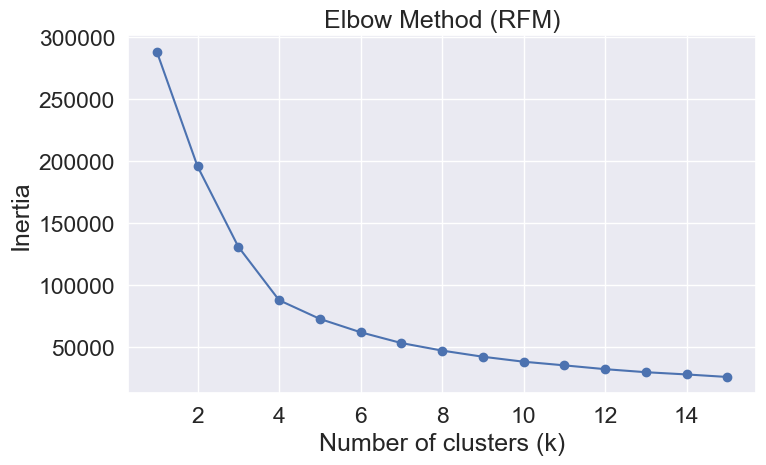

In [64]:
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

os.makedirs("outputs", exist_ok=True)

X_scaled = rfm_scaled   # or X_scaled = rfm_scaled.values if rfm_scaled is a dataframe

max_k = 15
cost = []

for k in range(1, max_k + 1):
    km = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        tol=1e-4,
        random_state=101
    )
    km.fit(X_scaled)
    cost.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, max_k + 1), cost, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method (RFM)")
plt.tight_layout()
plt.savefig("outputs/elbow_plot.png", dpi=200)
plt.show()


Force K = 5


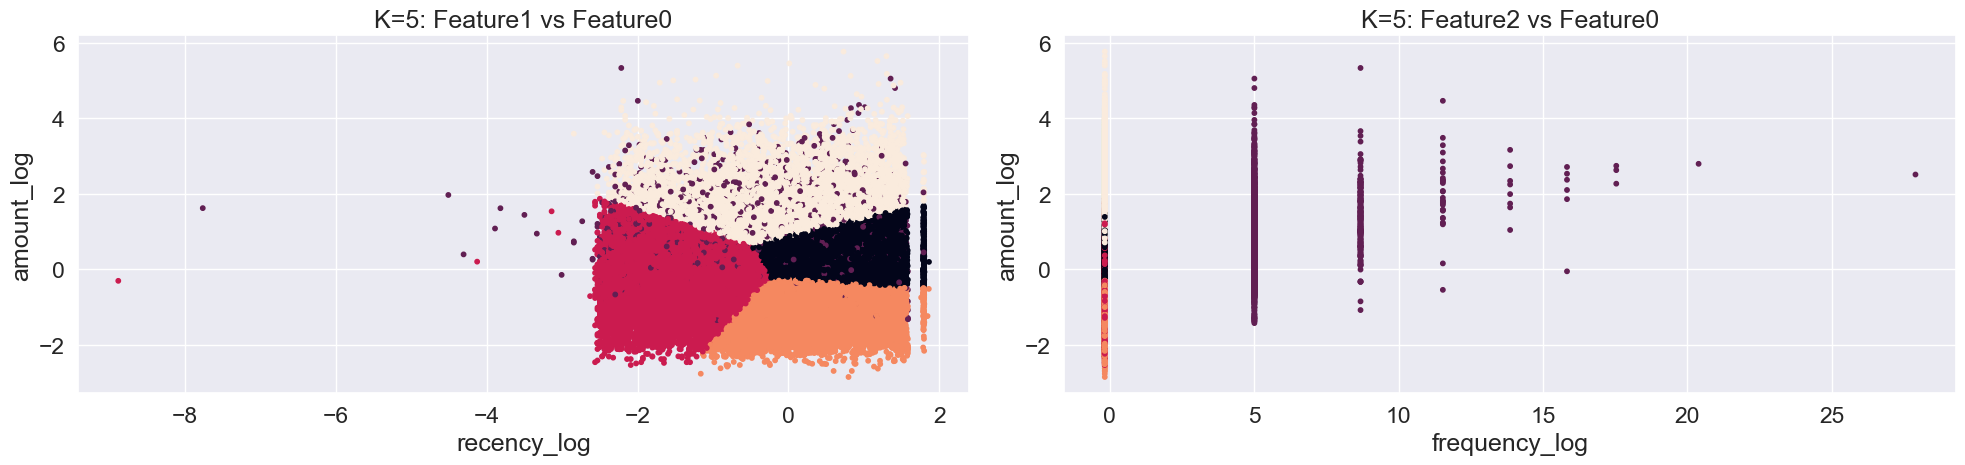

In [63]:
K_fixed = 5
print("Force K =", K_fixed)

model_5 = KMeans(
    n_clusters=K_fixed,
    init="k-means++",
    n_init=10,
    max_iter=300,
    tol=1e-04,
    random_state=101
)

model_5 = model_5.fit(X_scaled)
labels_5 = model_5.labels_

import os
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)

fig = plt.figure(figsize=(20, 5))

ax = fig.add_subplot(121)
ax.scatter(X_scaled[:, 1], X_scaled[:, 0], c=labels_5.astype(float), s=10)
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax.set_title("K=5: Feature1 vs Feature0")

ax = fig.add_subplot(122)
ax.scatter(X_scaled[:, 2], X_scaled[:, 0], c=labels_5.astype(float), s=10)
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])
ax.set_title("K=5: Feature2 vs Feature0")

plt.tight_layout()
plt.savefig("outputs/cluster_scatter.png", dpi=200)
plt.show()


In [58]:
# kết nối
conn = pyodbc.connect(conn_str)
cursor = conn.cursor()

# Tăng tốc executemany
cursor.fast_executemany = True

records = df_update[['clusters_5', 'cluster_name', 'description', 'customer_key']].values.tolist()

sql = """
UPDATE mart.customer_rfm_clusters
SET 
    clusters     = ?,      -- số cụm (0..4)
    cluster_name = ?,      -- tên cụm
    description  = ?       -- mô tả cụm
WHERE customer_key = ?;
"""

cursor.executemany(sql, records)
conn.commit()

cursor.close()
conn.close()
